In [1]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


def residualize_variable_kfold(data, y_var, x_vars, n_folds=5):
    X = data[x_vars].values
    y = data[y_var].values
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    residuals = np.zeros(len(y))

    for train_idx, test_idx in kf.split(X):
        # Split data
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Train model
        params = {
            'objective': 'regression',
            'metric': 'mse',
            'learning_rate': 0.1,
            'max_depth': 5,
            'verbose': -1
        }
        lgb_train = lgb.Dataset(X_train, y_train)
        model = lgb.train(params, lgb_train, num_boost_round=100)

        # Predict and calculate residuals
        y_pred = model.predict(X_test)
        residuals[test_idx] = y_test - y_pred

    return residuals


# Residualize data
def residualize_data(data, y='electricity_price', n_folds=5):
    data['solar_resid'] = residualize_variable_kfold(
        data, 'solar_forecast', ['solar_capacity', 'daylight_hours', 'Hour', 'Month'], n_folds=n_folds
    )
    confounders = ['daylight_hours', 'Hour', 'Year', 'Month', 'Day', 'total_load', 'gas_price', 'co2_price',
                   'wind_forecast']
    data['price_resid'] = residualize_variable_kfold(
        data, y, confounders, n_folds=n_folds
    )
    return data


# Fit residualized model
def fit_residualized_model(data):
    scaler = StandardScaler()
    X_residualized = data[['solar_resid']]
    y_residualized = data['price_resid']

    pipeline_residualized = Pipeline([
        ('scaler', scaler),
        ('regressor', LinearRegression())
    ])

    pipeline_residualized.fit(X_residualized, y_residualized)
    coef_residualized = pipeline_residualized.named_steps['regressor'].coef_
    scale_residualized = pipeline_residualized.named_steps['scaler'].scale_

    return coef_residualized / scale_residualized

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d
# from DML_utils_solar import residualize_data, fit_residualized_model

In [4]:
# Load data
df = pd.read_csv('/Users/emircanince/Desktop/power/data/causal_data.csv')
df = df[df['solar_penetration'] != 0]
df.reset_index(drop=True, inplace=True)
df.head()

,Date,solar_forecast,wind_off_forecast,wind_on_forecast,total_load,solar_capacity,wind_off_capacity,wind_on_capacity,electricity_price,daylight_hours,...,gas_price,wind_forecast,wind_capacity,solar_penetration,wind_penetration,solar_binary,Hour,Day,Month,Year
0,2022-01-01 08:00:00,1342.60,15526.02,67844.42,159194.01,67479,8149,58014,49.66,8.04,...,72.752,83370.44,66163,0.84,52.37,1,8,1,1,2022
1,2022-01-01 09:00:00,8127.05,14846.09,61869.05,170726.78,67479,8149,58014,70.05,8.04,...,72.752,76715.14,66163,4.76,44.93,1,9,1,1,2022
2,2022-01-01 10:00:00,17034.81,15508.06,55094.49,180556.89,67479,8149,58014,76.79,8.04,...,72.752,70602.55,66163,9.43,39.10,1,10,1,1,2022
3,2022-01-01 11:00:00,24339.89,16568.78,48456.82,192071.69,67479,8149,58014,84.10,8.04,...,72.752,65025.60,66163,12.67,33.85,1,11,1,1,2022
4,2022-01-01 12:00:00,27640.55,17563.98,42444.89,195864.57,67479,8149,58014,94.74,8.04,...,72.752,60008.87,66163,14.11,30.64,1,12,1,1,2022


In [5]:
df.shape

(14771, 21)

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Scale the relevant columns
df['total_load'] = df['total_load'] / 1000
df['wind_forecast'] = df['wind_forecast'] / 1000
df['solar_forecast'] = df['solar_forecast'] / 1000

# Sort the DataFrame by solar penetration
df = df.sort_values(by='solar_penetration')

# Parameters for sliding window
window_size = 5000
step_size = 500
n_iterations = 100  # Number of bootstraps

# Store CATE and corresponding penetration levels for each window
results = []

# Total number of windows
total_windows = (len(df) - window_size) // step_size + 1

# Sliding window analysis
for start in range(0, len(df) - window_size + 1, step_size):
    window_data = df.iloc[start:start + window_size]

    # Calculate the mean solar penetration for the current window
    mean_solar_penetration = window_data['solar_penetration'].mean()

    # Use tqdm for bootstrap iterations
    with tqdm(total=n_iterations, desc=f'Window {start // step_size + 1}/{total_windows}', leave=False) as pbar:
        # Bootstrap for the current window
        for _ in range(n_iterations):
            random_subset = window_data.sample(n=min(len(window_data), window_size), replace=True)
            df_residualized = residualize_data(random_subset, y='electricity_price')
            res = fit_residualized_model(df_residualized)

            # Append the mean solar penetration and CATE to results
            results.append({
                'mean_solar_penetration': mean_solar_penetration,
                'cate': res[0]  # Extract the first (and only) coefficient
            })
            pbar.update(1)  # Update the progress bar

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save raw results
# results_df.to_csv('/Users/emircanince/Desktop/power/data/results_solar.csv', index=False)
# results_dataset = pd.read_csv('/Users/emircanince/Desktop/power/renewables/png/results_solar.csv')
results_dataset = results_df

# Group by mean solar penetration and calculate mean and quantiles for CATE
mean_cate_df = results_dataset.groupby('mean_solar_penetration')['cate'].agg(['mean']).reset_index()
mean_cate_df['lower_ci'] = results_dataset.groupby('mean_solar_penetration')['cate'].quantile(0.1).values
mean_cate_df['upper_ci'] = results_dataset.groupby('mean_solar_penetration')['cate'].quantile(0.9).values

# Apply Gaussian smoothing
sigma_smoothing = np.var(mean_cate_df['mean'])
mean_cate_df['smoothed_mean'] = gaussian_filter1d(mean_cate_df['mean'], sigma=sigma_smoothing)
mean_cate_df['smoothed_lower_ci'] = gaussian_filter1d(mean_cate_df['lower_ci'], sigma=sigma_smoothing)
mean_cate_df['smoothed_upper_ci'] = gaussian_filter1d(mean_cate_df['upper_ci'], sigma=sigma_smoothing)

In [18]:
results_df.to_csv('/Users/emircanince/Desktop/power/data/results_solar.csv', index=False)

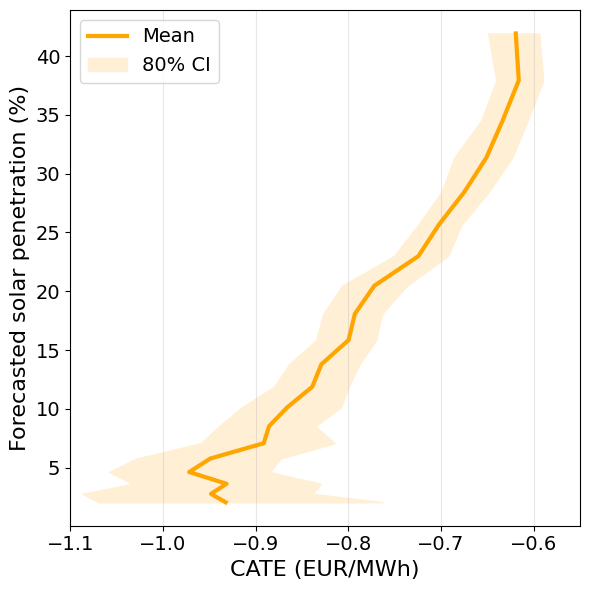

In [15]:
# Plotting the smoothed mean CATE against mean solar penetration with 80% CI
plt.figure(figsize=(6, 6), dpi=100)
plt.plot(mean_cate_df['smoothed_mean'], mean_cate_df['mean_solar_penetration'], marker='', linestyle='-',
         color='orange', label='Mean', lw=3)
plt.fill_betweenx(mean_cate_df['mean_solar_penetration'], mean_cate_df['smoothed_lower_ci'],
                  mean_cate_df['smoothed_upper_ci'],
                  color='papayawhip', alpha=1, label='80% CI')
plt.ylabel('Forecasted solar penetration (%)', fontsize=16)  # Now this is on y-axis
plt.xlabel('CATE (EUR/MWh)', fontsize=16)  # Now this is on x-axis
# plt.axvline(0, color='gray', linestyle='-', lw=.8)  # Add a vertical line at x=0
plt.grid(axis='x', linestyle='-', alpha=0.3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.xlim(-1.1, -0.55)
# plt.savefig('/Users/emircanince/Desktop/power/renewables/png/smooth_cate_solar.png', format='png', dpi=600)
plt.show()

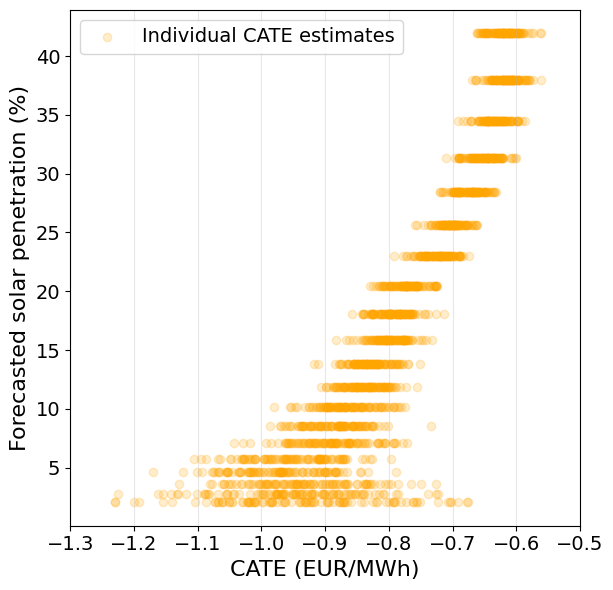

In [17]:
plt.figure(figsize=(6, 6), dpi=100)
plt.scatter(results_df['cate'], results_df['mean_solar_penetration'], alpha=0.2, color='orange',
            label='Individual CATE estimates')
plt.axvline(0, color='k', linestyle='-', lw=1, alpha=0.5)  # Add a vertical line at x=0
plt.xlabel('CATE (EUR/MWh)', fontsize=16)
plt.ylabel('Forecasted solar penetration (%)', fontsize=16)
plt.grid(axis='x', linestyle='-', alpha=0.3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.xlim(-1.3, -0.5)
# plt.savefig('/Users/emircanince/Desktop/power/renewables/png/individual_cate_solar.png', format='png', dpi=600)
plt.show()